In [48]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

In [49]:
#https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
redWine_df = pd.read_csv('winequality-red.csv', sep=';')
redWine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [50]:
#Get target vector as a separate numpy array and remove target column from dataframe.
#Simplify the problem to binary in which wines are either good (score>7) or bad(score<7)

Y = redWine_df["quality"].values
redWine_df = redWine_df.drop('quality', axis = 1)
Y = np.asarray([1 if i>=7 else 0 for i in Y])
redWine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [51]:
print(Y)

[0 0 0 ... 0 0 0]


In [52]:
#Save feature information in dataframe as numpy array
#Plot cross validation scores of random forests as a function of the number of trees in the random forest, ranging from 1 (simple decision tree) to 40 random
#Use 10fold cross validation

X = redWine_df.as_matrix()
scores = []
for val in range(1,41):
    clf = RandomForestClassifier(n_estimators=val)
    validated = model_selection.cross_val_score(clf, X, Y, cv=10)
    scores.append(validated)


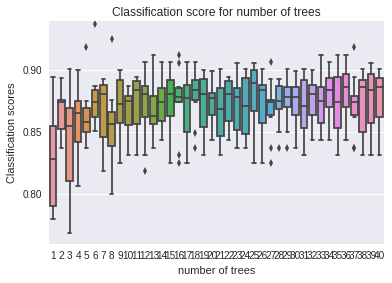

In [55]:
sns.boxplot(range(1,41), scores)
plt.xlabel('number of trees')
plt.ylabel('Classification scores')
plt.title('Classification score for number of trees')
plt.show()

In [56]:
##Evaluating the Unbalanced Class
#In Binary classification problems, accuracy can be misleading if one class(say, bad wine) is much more common than another (say, good wine). This is when the classes are unbalanced.
#Print the percentage of wines that are labeled as bad in the dataset and plot a boxplot, draw a line across the plot denoting the accuracy of always guessing zero.

len_y = len(Y)
temp = [i for i in Y if i==0]
temp_1=temp.count(0)
percentage = float(temp_1)/float(len_y)

In [58]:
print percentage 

86.4290181363


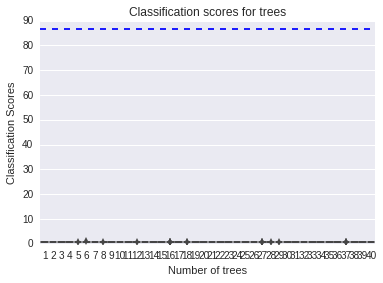

In [60]:
sns.boxplot(range(1,41), scores)
plt.axhline(y = percentage, ls='--')
plt.xlabel('Number of trees')
plt.ylabel('Classification Scores')
plt.title('Classification scores for trees')
plt.show()

In [65]:
#F1 Score is the harmonic mean of recall and precision.
#F1 = (2*recall*precision)/ (recall+precision)
scores = []
for val in range(1,41):
    clf = RandomForestClassifier(n_estimators = val)
    validated = model_selection.cross_val_score(clf, X, Y, cv=10, scoring='f1')
    scores.append(validated)    

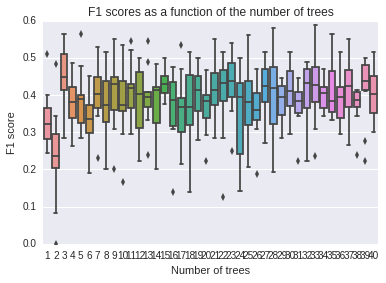

In [66]:
sns.boxplot(range(1,41), scores)
plt.xlabel('Number of trees')
plt.ylabel('F1 score')
plt.title('F1 scores as a function of the number of trees')
plt.show()

##Scores are clustered around 40% mark

In [67]:
##Setting the cutoff value for prediction
#When the classes in the training data are unbalanced, the prediction probabilities calculated y the classifier can be inaccurate because many classifiers do not know how to adjust for this imbalance.
#This problem is solved using calibration.

In [74]:
##Predict proba function in scikit-learn
#Fit a random forest classifier to wine data using 15trees.
#Compute the predicted probabilities that the classifier assined to each of the training samples using predict_proba method.
#test case - construct prediction based on the predicted probabilities of being in class 1 >0.5  and class 0 otherwise.

clf = RandomForestClassifier(n_estimators =15)
clf.fit(X,Y)
##predict_proba returns 2columns, column1 is class) and column2 is class1
(clf.predict_proba(X)[:,1] > 0.5).astype(int)

array([0, 0, 0, ..., 0, 0, 0])

In [77]:
#Using 10-fold cross validation, find a cutoff in np.arange(0.1,0.9,0.1) that gives the best average F1 score when converting prediction probabilities from a 15-tree random forest classifier into predictions.

def cutoff_predict(clf, X, cutoff):
    return (clf.predict_proba(X)[:,1]>cutoff).astype(int)

scores = []

def custom_f1(cutoff):
    def f1_cutoff(clf, X, Y):
        ypred = cutoff_predict(clf, X, cutoff)
        return sklearn.metrics.f1_score(Y, ypred)
    return f1_cutoff

for cutoff in np.arange(0.1, 0.9, 0.1):
    clf = RandomForestClassifier(n_estimators=15)
    validated = model_selection.cross_val_score(clf, X, Y, cv=10, scoring = custom_f1(cutoff))
    scores.append(validated)

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


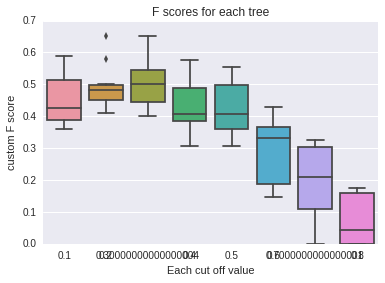

In [80]:
sns.boxplot(np.arange(0.1,0.9,0.1), scores, names=np.arange(0.1,0.9,0.1))
plt.title('F scores for each tree')
plt.xlabel('Each cut off value')
plt.ylabel('custom F score')
plt.show()